In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

import cv2 # Used to rotate MNIST images

In [2]:
class rotate_img(object):
  def __call__(self, img):
    rotation_transform = transforms.RandomRotation((0,360))
    rotated_img = rotation_transform(img)

    return rotated_img

In [3]:
# MNIST images
train = torchvision.datasets.MNIST('', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(),
                                                                                                rotate_img()]))
test = torchvision.datasets.MNIST('', train=False, download=True,transform=transforms.Compose([transforms.ToTensor(),
                                                                                               rotate_img()]))
trainset = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 69973578.37it/s]


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 73061335.24it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 19559290.80it/s]


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12777014.60it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



# 1. Rotating MNIST images
First part of the project will be devising a method to rotate the MNIST data set to expand the number of training and testing images.

tensor(6)


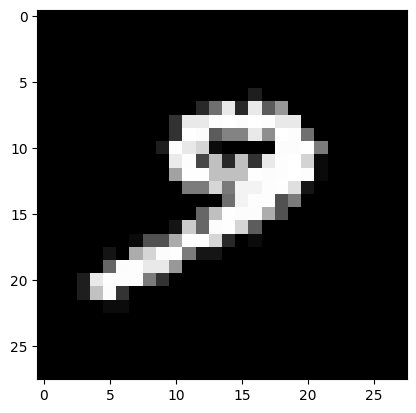

In [14]:
# Original image
images, labels = next(iter(trainset))
plt.imshow(images[0].reshape(28,28), cmap="gray")
print(labels[0])

# 2. Build a Model

In [5]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__() 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.pool  = nn.AvgPool2d(kernel_size=2)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        y = self.conv1(x)
        y = F.relu(y)
        y = self.pool(y)
        y = self.conv2(y)
        y = F.relu(y)
        y = self.pool(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = F.relu(y)
        y = self.fc2(y)
        y = F.relu(y)
        y = self.fc3(y)
        return y

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = LeNet5().to(device)
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

# 3. Training and Testing

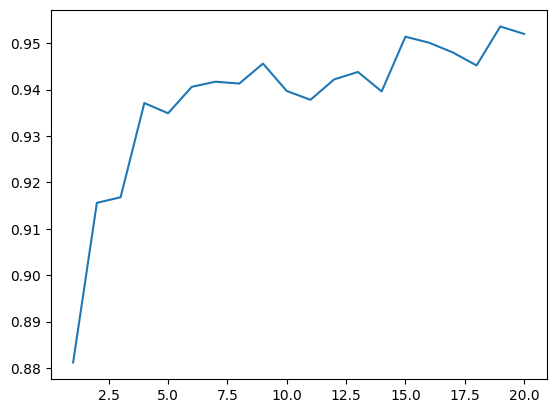

In [7]:
accuracy_output = np.zeros(20)
loss_array = np.zeros(20)

for epoch in range(20): 
  for data in trainset:  
    X, y = data
    X = X.to(device)
    y = y.to(device) 
    net.zero_grad()  
    output = net(X)  
    loss = loss_criterion(output, y)  

    # Backpropergation 
    loss.backward()  
    optimizer.step()  

    correct = 0
    total = 0
  
  loss_array[epoch] = loss

  with torch.no_grad():
    for data in testset:
      X, y = data
      X = X.to(device)
      y = y.to(device)
      output = net(X)

      for idx, i in enumerate(output):
        if torch.argmax(i) == y[idx]:
          correct += 1
        total += 1
    accuracy_output[epoch] = round(correct/total, 4)


epoch = np.array([(i + 1) for i in range(20)])
plt.plot(epoch, accuracy_output)

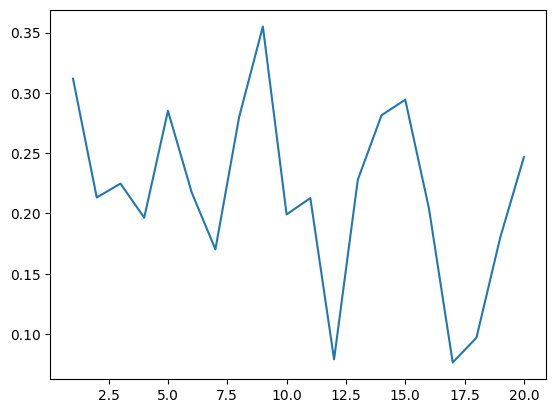

In [8]:
plt.plot(epoch, loss_array, label = "Loss")

In [9]:
print("Accuracy: ", round(accuracy_output[19], 2))

Accuracy:  0.95


tensor(4)


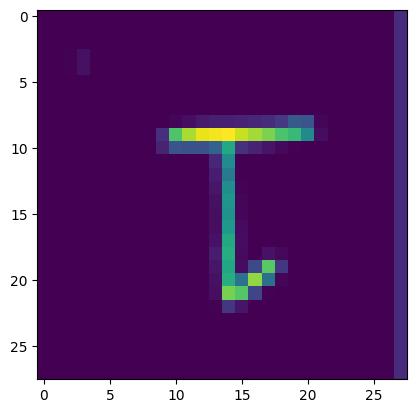

In [54]:
from PIL import Image

img = Image.open('1.png')

transform = transforms.Resize((28,28))
resized_img = transform(img)
bw_img = transforms.Grayscale()(resized_img)
plt.imshow(bw_img)

tensor_img = transforms.ToTensor()(bw_img)
with torch.no_grad():
  output = net(tensor_img.view(-1,1,28, 28))
print(torch.argmax(output))
#print(output)